This is the model which intent to generate sequences with Shakespeare style.

In [243]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from google.colab import drive
from collections import Counter
import torchtext
drive.mount('/content/gdrive')
file_path = '/content/gdrive/My Drive/CSC413/harmlet.txt'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import random

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Then we process the data.

In [244]:
sentences = []
for line in open(file_path):
    if(line!="\n"):
      sentences.append(line[:-1].lstrip())

In [245]:
print(len(sentences))
print(sentences[2])
print(sentences[200])


4167
Dramatis Personae
For it is as the air, invulnerable,


There are 4456 sentences in harmlet and we chose one of the sentence as sample so that our model can generate the sample after training. 

In [246]:
print(sentences[1040]
sample=sentences[1040]

He closes with you in this consequence:


In [247]:
word = list(set(sample)) + ["<BOS>", "<EOS>"]
 # A mapping of index => word (string)
word_itos = dict(enumerate(word)) 
word_stoi = {word:index for index, word in word_itos.items()}
word_size = len(word)
print(word_itos)

{0: ':', 1: 't', 2: 'q', 3: 'o', 4: 'u', 5: 'n', 6: 'e', 7: 'w', 8: 's', 9: 'i', 10: ' ', 11: 'H', 12: 'c', 13: 'h', 14: 'y', 15: 'l', 16: '<BOS>', 17: '<EOS>'}


We are using a RNN model which means it not only produce the token but also produce a hidden state for the next token to produce. Here we bring in two special characters BOS and EOS which repersent the Begining input state and the end state of the sentence. The model start with the input of BOS and stop generate when it produce to the EOS.

Our model have three parts:

1. An **embedding** layer that takes a character index (sparse representation of a one-hot vector
   representing the character), and returns an **embedding** ${\bf x}^{(t)}$ for the character.
2. A **recurrent neural network** layer. We will use a `nn.GRU` unit which use folllowing function. At each time step,
   this layer will take the previous hidden state ${\bf h}^{(t-1)}$ and the embedding of
   a new generated token ${\bf x}^{(t)}$ and compute the new hidden state ${\bf h}^{(t)}$ representing
   *tokens not yet generated*.

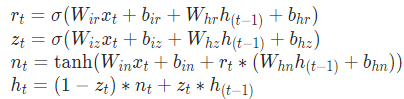

3. The projection MLP that takes the hidden state ${\bf h}^{(t)}$
   and computes teh distribution of the next character to generate.

In [248]:
class TextGenerator(nn.Module):
    def __init__(self,
                 vocab_size,    
                 embedding_size, 
                 hidden_size):  
        super(TextGenerator, self).__init__()

        # Embedding 
        self.embed = nn.Embedding(num_embeddings=vocab_size, 
                                  embedding_dim=embedding_size)  

        # recurrent neural network
        self.rnn = nn.GRU(input_size=embedding_size, 
                          hidden_size=hidden_size, 
                          batch_first=True)

        # a fully-connect layer that outputs a distribution over
        # the next token, given the RNN output
        self.proj = nn.Linear(in_features=hidden_size, 
                              out_features=vocab_size) 

    def forward(self, inp, hidden=None):
        emb = self.embed(inp)                  
        output, hidden = self.rnn(emb, hidden) 
        output = self.proj(output)            
        return output, hidden


This is a sample how we train model base on one sentence of the harmlet.
The problem we face is how to caculate the loss. In order to have a loss we should 

[Iter 100] Loss 0.024123
[Iter 200] Loss 0.006803
[Iter 300] Loss 0.003433
[Iter 400] Loss 0.002122
[Iter 500] Loss 0.001458
[Iter 600] Loss 0.001071
[Iter 700] Loss 0.000824
[Iter 800] Loss 0.000655
[Iter 900] Loss 0.000535
[Iter 1000] Loss 0.000445


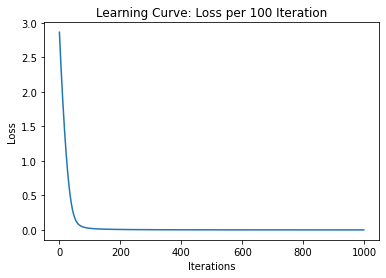

In [251]:
model = TextGenerator(word_size, 128, 128)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
senten_ch = ["<BOS>"] + list(sample) + ["<EOS>"]
senten_indices = [word_stoi[ch] for ch in sample]
senten_tensor = torch.Tensor(senten_indices).long().unsqueeze(0)
all_losses=[]
for it in range(1000): 
    optimizer.zero_grad()
    output, hidden =  model(senten_tensor[:,:-1]) 
    target = senten_tensor[:,1:] 
    loss = criterion(output.reshape(-1, word_size), 
               target.reshape(-1))     
    loss.backward()
    optimizer.step()
    all_losses.append(float(loss))
    if (it+1) % 100 == 0:
        print("[Iter %d] Loss %f" % (it+1, float(loss)))

plt.figure()
plt.title("Learning Curve: Loss per 100 Iteration")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(all_losses)

We build the method that generate the sentence. It takes the model max length of the sentence. it use the front character and the hidden state produce the current character and next character. There are two case we stop the Generation, one is when we reach the max length of the sentence. The other one is when we reach EOS which means we reach the end of the sentence.

Notice there is a paremeter called temperature which I believe is the entropy of this generation. When the temperature going high the character will become more and more ramdom. The reason for that is there is no right answer for this model to generation. This model should be able to generate a whole set of the sentence. However it should also not be too ramdom. It should follow some kind of rules(like grammar).

In [230]:
def sample_sequence(model,word_stoi,word_itos, max_len=100, temperature=0.8):
    generated_sequence = ""
   
    inp = torch.Tensor([word_stoi["<BOS>"]]).long()
    hidden = None
    for p in range(max_len):
        output, hidden = model(inp.unsqueeze(0), hidden)
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = int(torch.multinomial(output_dist, 1)[0])
        predicted_char = word_itos[top_i]
        
        if predicted_char == "<EOS>":
            break
        generated_sequence += predicted_char       
        inp = torch.Tensor([top_i]).long()
    return generated_sequence

In [ ]:
print(sample_sequence(model, word_stoi,word_itos,temperature=0.8))

you in this consequence::e:closes with you in this consequence::closes with you in this consequence:


Now we intent to train our model for the single batch

In [255]:
vocab = list(set([w for s in sentences for w in s])) + ["<BOS>", "<EOS>"]
vocab_itos = dict(enumerate(vocab))
vocab_stoi = {word:index for index, word in vocab_itos.items()}
size_all = len(vocab)
print(vocab_itos)
def train(model, data,vocab_stoi,vocab_itos,size_all, batch_size=1, num_epochs=1, lr=0.001, print_every=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    it = 0
    data_batch=[]
    loss_a=[]
    while (len(data_batch)<batch_size):
      a=random.randint(0,len(data)-1)
      if data[a] not in data_batch:
        data_batch.append(data[a])
    for e in range(num_epochs):
        # get training set
        avg_loss = 0
        for senten in data_batch:
            se_ch = ["<BOS>"] + list(senten) + ["<EOS>"]
            se_indices = [vocab_stoi[ch] for ch in se_ch]
            se_tensor = torch.Tensor(se_indices).long().unsqueeze(0)
            target = se_tensor[:,1:]
            inp = se_tensor[:,:-1]
            optimizer.zero_grad()
            output, hidden =  model(inp)
            loss = criterion(output.reshape(-1, size_all),
                 target.reshape(-1))
            loss.backward()
            optimizer.step()

            avg_loss += loss
            it += 1 
            if it % print_every == 0:
                print("[Iter %d] Loss %f" % (it+1, float(avg_loss/print_every)))
                print("    " + sample_sequence(model,vocab_stoi,vocab_itos, 140, 0.8))
                loss_a.append(float(avg_loss/print_every))
                avg_loss = 0
    plt.figure()
    plt.plot(all_losses)
model = TextGenerator(size_all, 128, 128)

{0: 'I', 1: '.', 2: ':', 3: ',', 4: 'C', 5: 'T', 6: ')', 7: 'R', 8: 'b', 9: 'i', 10: 'n', 11: 'y', 12: 'k', 13: 'p', 14: 'J', 15: '?', 16: 'S', 17: 'z', 18: '!', 19: 'B', 20: '-', 21: 't', 22: 'f', 23: '[', 24: ';', 25: 'q', 26: 'E', 27: 'U', 28: 'G', 29: 'm', 30: 'W', 31: 'h', 32: 'D', 33: 'Y', 34: 's', 35: 'd', 36: '&', 37: 'x', 38: 'V', 39: 'l', 40: 'j', 41: 'r', 42: 'M', 43: 'P', 44: 'a', 45: '"', 46: 'O', 47: 'e', 48: 'w', 49: 'L', 50: 'v', 51: 'c', 52: '1', 53: "'", 54: 'o', 55: 'A', 56: 'N', 57: 'u', 58: 'K', 59: ']', 60: 'g', 61: ' ', 62: 'H', 63: 'F', 64: 'Q', 65: '(', 66: '<BOS>', 67: '<EOS>'}


[Iter 101] Loss 0.075766
    be I lol, ot therphise be winst thin.
[Iter 201] Loss 0.107953
    Wh you. O my1 I rupine.
[Iter 301] Loss 0.101540
    Whey soth the strand demi-nateech Lou.
[Iter 401] Loss 0.078033
    Exeunt.
[Iter 501] Loss 0.054956
    Ham. Ay, so, God dingle spies.
[Iter 601] Loss 0.045676
    When sorrows come, they come not single spies.
[Iter 701] Loss 0.045823
    And from her fair and unpolluted flesh  
[Iter 801] Loss 0.047650
    Exeunt.
[Iter 901] Loss 0.005362
    be otherwise.
[Iter 1001] Loss 0.009498
    Why seems it so particular with thee?
[Iter 1101] Loss 0.014020
    A noise within: 'Let her come in.'
[Iter 1201] Loss 0.018521
    Exeunt.
[Iter 1301] Loss 0.023082
    Ham. Ay, so, God b' wi' ye!
[Iter 1401] Loss 0.029932
    As had he been incorps'd and demi-natur'd
[Iter 1501] Loss 0.035373
    Before mine uncle. I'll observe his looks;
[Iter 1601] Loss 0.039415
    Exeunt.
[Iter 1701] Loss 0.004832
    Exeunt.
[Iter 1801] Loss 0.008543
    Rey. Ay, 

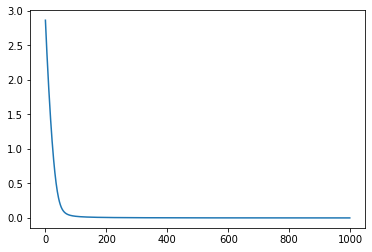

In [256]:
#train(model, sentences,vocab_stoi,size_all, batch_size=1, num_epochs=10, lr=0.004, print_every=1)
train(model, sentences,vocab_stoi,vocab_itos,size_all, batch_size=32, num_epochs=100, lr=0.004, print_every=100)

Basicly we chose one batch of the sentences of the harmlet to train our model and try to generate each sentence as close as possibble. At the end the model will fit the batch of sentences.

In [240]:
for x in range(10):
  print(sample_sequence(model,vocab_stoi,vocab_itos, temperature=0.8))
print("==================================")
for x in range(10):
  print(sample_sequence(model,vocab_stoi,vocab_itos, temperature=1.0))
print("==================================")
for x in range(10):
  print(sample_sequence(model,vocab_stoi,vocab_itos, temperature=1.5))



For I mine eyes will rivet to his face,
Ham. 'The mobled queen'?
defence?
Hecuba.
Ham. 'The mobled queen'?
Hecuba.
Hor. Of that I shall have also cause to speak,
Mess. Save Yourself, my lord:
Hecuba.
Mess. Save Yourself, my lord:
defence?
And prey on garbage.
And prey on garbage.
And prey on garbage.
To you alone.
Hecuba.
Guos. Faith, there has been much to do on both sides; and the nation
Ham. 'The mobled queen'?
Guil. Happy in that we are not over-happy.
defence?
of our fellowship, by the conband queen 'therestallone.s; Nifay,
Will you be rul'd by me?
Ros.] Faitrad:
That he which hath your ngown not wewnhan kind!
Hor. Of that I shall have also cause to speak,
Hecuba.
To Norway, uncle of young Fortinbras,
Mess. Save Yourself, my lord:
[to so Hamlet's Father.
King. Go seek him there. [To Attendxven to his manen, to necxtban] do e?


As we can see because we only train the model with only one of the batch, the model may overfit the batch and always generate the origin sentence from the batch. We don't want that , therefore we should feed the model more batchs.

In [258]:
def train_batchs(model, data,vocab_stoi,vocab_itos,size_all, batch_size=1, num_epochs=1, lr=0.001, print_every=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    it = 0
    random.shuffle(data)
    count=0
    while(count+batch_size<len(data)):
      for e in range(num_epochs):
        # get training set
        avg_loss = 0
        for senten in data[count:count+batch_size]:
            se_ch = ["<BOS>"] + list(senten) + ["<EOS>"]
            se_indices = [vocab_stoi[ch] for ch in se_ch]
            se_tensor = torch.Tensor(se_indices).long().unsqueeze(0)
            target = se_tensor[:,1:]
            inp = se_tensor[:,:-1]
            optimizer.zero_grad()
            output, hidden =  model(inp)
            loss = criterion(output.reshape(-1, size_all),
                 target.reshape(-1))
            loss.backward()
            optimizer.step()

            avg_loss += loss
            it += 1 
            if it % print_every == 0:
                print("[Iter %d] Loss %f" % (it+1, float(avg_loss/print_every)))
                print("    " + sample_sequence(model,vocab_stoi,vocab_itos, 140, 0.8))
                avg_loss = 0
      count+=batch_size

In [259]:
model = TextGenerator(size_all, 128, 128)
train_batchs(model, sentences,vocab_stoi,vocab_itos,size_all, batch_size=32, num_epochs=10, lr=0.004, print_every=100)

[Iter 101] Loss 0.074606
    Ham. At mer.
[Iter 201] Loss 0.103452
    Kis't blout burhe and mor;t your wighat Lord.
[Iter 301] Loss 0.096992
    Excombe to thacat the blush ann thoughts the it mace
[Iter 401] Loss 0.239292
    Ham. Whigut.
[Iter 501] Loss 0.163801
    Ham. Sir, in me you go sere.
[Iter 601] Loss 0.123243
    Lord. My fatelg theas a the Nemnean comest a houndleshy princes at a sent omth.
[Iter 701] Loss 0.553091
    And my lae come thou that tha a won'tn.
[Iter 801] Loss 0.271380
    Hase parille. Ir.
[Iter 901] Loss 0.017462
    I am and jud;
[Iter 1001] Loss 0.159447
    Ham. Dind ans;
[Iter 1101] Loss 0.095429
    [Laertes theseres the Freany famlt doenc! 'tous ove.
[Iter 1201] Loss 0.059275
    Ham. I humbly thou; well, well, well.
[Iter 1301] Loss 0.613389
    Enter Hamle.
[Iter 1401] Loss 0.208671
    The bell then wptase, [Econder Hamlet wivent,
[Iter 1501] Loss 0.117669
    Th' observ- qute,
[Iter 1601] Loss 0.084448
    Hor. What is't, my lord? Wik y pics agai

In [260]:
for x in range(10):
  print(sample_sequence(model,vocab_stoi,vocab_itos, temperature=0.8))
print("==================================")
for x in range(10):
  print(sample_sequence(model,vocab_stoi,vocab_itos, temperature=1.0))
print("==================================")
for x in range(10):
  print(sample_sequence(model,vocab_stoi,vocab_itos, temperature=1.5))

Of he will the will no pation,
Yet I,
Wull him. Prish cost and and dosoo?
Laer. The will this madiark
That shat she reard
Swear.
Withoser then Pringuertion his nate
Clown. Ths may, Hamlete not no the remove noth in't to that namet I,
Swear.
Yet I,
Guil. Pright hefur mights ye I,
Swear.
Well minisuletse that sornturser,
Guil. Prisfen as in his is to reard be? Thou my lord?  
Swear, and Is mlam. Ho purthis me delf, nose com with figation dim. Thath be did will not with dose 
Swear.
Ist times  
Whosco?
Now he we breuch and the with father, and Noptes thou, makem me it?
Theromaske the  
Now Prome ad withem I Dowson agh my doroughou,
Theer gink,
is lighte
Thuncive daing hear.
Quilaine.  
Yeth burial inquausets arwer quimet his quier,
Is! Lelf mindeecd, bo you, orawent Lithem.
No,' rourly,. O, in his know, he tidelf likn made
scson of give re lyem.
Queen. Pallk she grewhes, th' shall not pourson,


As we can see the model is much better than before. 